In [1]:
# this note book contain the implementation code for sharing problem in admm
# problem: minimize sum f_i(xi) + sigma*norm1(sum x_i)

In [3]:
# data loading function x

In [81]:
import scipy
import numpy as np

In [307]:
data = scipy.io.loadmat(".//data//10 Agents//p5//Set4")

In [309]:
#extract data
gamma = data['Phi'][0] ## function hessian (include 10: 5x5 matrix)
theta = data['theta'][0] ## theta fi_xi = (xi-theta_i) @ phi @ (xi-theta)
# J_solver = data['J_solver'] 
solution = data['solution']

In [311]:
theta[0].shape[0]

5

In [313]:
gamma

array([array([[ 3.45678847, -0.41634739,  0.09239158, -0.51805927, -0.3630161 ],
              [-0.41634739,  1.78424548, -0.329426  ,  0.60512552,  0.66709242],
              [ 0.09239158, -0.329426  ,  2.64751362, -0.36835663, -0.15926588],
              [-0.51805927,  0.60512552, -0.36835663,  2.92114263,  0.60829058],
              [-0.3630161 ,  0.66709242, -0.15926588,  0.60829058,  1.58449853]]),
       array([[ 1.41859358, -0.24183159,  0.4506265 , -0.05622287,  0.50369355],
              [-0.24183159,  1.44518591,  0.14800796, -0.09538209, -0.68928998],
              [ 0.4506265 ,  0.14800796,  3.00568404, -0.12587592,  0.29075848],
              [-0.05622287, -0.09538209, -0.12587592,  1.70012094, -0.37665903],
              [ 0.50369355, -0.68928998,  0.29075848, -0.37665903,  2.61458391]]),
       array([[ 3.60945537, -0.36148388,  0.55788104, -0.43928001, -0.31652328],
              [-0.36148388,  2.49940256,  0.69892463, -0.8044575 ,  0.18442887],
              [ 0.557881

In [315]:
len(gamma)

10

In [317]:
np.linalg.eigvals(gamma[0])

array([4.35992488, 2.940218  , 2.37655269, 1.71749317, 1.        ])

In [319]:
# checking eigenvalue to ensure input matrix is PSD
for i in range (len(gamma)):
    eighen_val = np.linalg.eigvals(gamma[i])
    if np.all(eighen_val >= 0):
        print(f"Input matrix {i} satisfy")
    else:
        print(f"Input matrix %s DOES not satisfy",i)



Input matrix 0 satisfy
Input matrix 1 satisfy
Input matrix 2 satisfy
Input matrix 3 satisfy
Input matrix 4 satisfy
Input matrix 5 satisfy
Input matrix 6 satisfy
Input matrix 7 satisfy
Input matrix 8 satisfy
Input matrix 9 satisfy


In [321]:
# stopping criteria
primal_residual = 1e-4
dual_residual = 1e-3

## Problem

Consider the sharing problem of ADMM, perform with n agents collaborate to solve the global optimization problem as bellow. where the $x_i \in R^n$ and hessian matrix $\Gamma_i \in R^{n x n}$, consider the $z_i$ is copy of $x_i$. The ADMM form of the problem can be written as:

\begin{aligned}
\min_{\{x_i,z_i\}} \quad 
& \sum_{i=1}^n (x_i-\theta_i)^\top \Gamma_i (x_i-\theta_i)
\;+\; \zeta\left\|\sum_{i=1}^n z_i\right\|_1 \\
\text{s.t.}\quad & x_i - z_i = 0,\qquad i=1,\dots,n.
\end{aligned}

Here the $g(x_i)$ is the shared objective of our problem, $f_i(x_i)$ is the local cost function. Then the augumented largrangian function is considered as:

In [324]:
# set the soft function to solve the z-update

def soft_threshold(v, tau):
    return np.sign(v) * np.maximum(np.abs(v) - tau, 0)

In [328]:
def cho_solve(L, b):
    # solving linear system of x by cholesky decomp (L @ L^T) x = b
    y = np.linalg.solve(L, b)
    return np.linalg.solve(L.T, y)

In [330]:
def stack_norm_sq(vecs):
    #sum_i ||v_i||^2
    return sum(np.dot(v, v) for v in vecs)

### Define the solver ADMM

In [367]:
class Sharing_ADMM_L1Norm:
    def __init__(self, gamma_list, theta_list, zeta=1.0, rho=1.0, eps_abs=1e-4, eps_rel=1e-3, max_iters=300):
        """
        input: 
        + gamma: list of pxp PSD matrix
        + theta: coresponding theta
        + zeta: l1 weight
        + rho: penalty for the augumented part
        """
        self.N = len(gamma_list)
        assert self.N == len(theta_list), "number of theta and gamma missmach"
        self.p = theta_list[0].shape[0] #dimension input

        #store data
        self.G = [np.array(Gi, dtype=float) for Gi in gamma_list]
        self.theta = [np.array(ti, dtype=float).reshape(-1) for ti in theta_list]
        self.residual_storage = []

        # hyper-params:
        self.zeta = float(zeta)
        self.rho = float(rho)
        self.eps_abs  = float(eps_abs)
        self.eps_rel  = float(eps_rel)
        self.max_iters = int(max_iters)

        # variable:
        self.x = [np.zeros(self.p) for _ in range(self.N)] #store solution each iteration
        self.z_blocks = [np.zeros(self.p) for _ in range(self.N)]
        self.u_shared = np.zeros(self.p) #used when k >= 1

        self.u_blocks0 = [np.zeros(self.p) for _ in range(self.N)] #use only for k = 0

        self.z_global = np.zeros(self.p) #aggregated z

        # does not change the rho so we can store the cholesky decomp
        I = np.eye(self.p)
        self.L = []

        for i in range(self.N):
            Ai = 2.0 * self.G[i] + self.rho * I ## as when solving the linear system of the optimizing the x
            self.L.append(np.linalg.cholesky(Ai))

    # since the admm with the random initialize of the 
    def first_iter(self):
        # at the first iteration the update of x with the average value will not suitable hence we will optimize the x_i through normal
        N, rho = self.N, self.rho

        # x^i(k+1) -> sovlve (2G + rho*I)@x^k = 2G * theta + rho*(z_ik - u_ik)
        for i in range(N):
            rhs = 2.0 * self.G[i] @ self.theta[i] + rho * (self.z_blocks[i] - self.u_blocks0[i])
            self.x[i] = cho_solve(self.L[i], rhs) #apply cho solve to solve the linear system

        #calculate the z_bar
        a = [self.x[i] + self.u_blocks0[i] for i in range(N)]
        a_bar = sum(a) / N

        tau = self.zeta / rho
        self.z_global = soft_threshold(a_bar, tau)

        for i in range(N):
            self.z_blocks[i] = a[i] + (self.z_global - a_bar) # calculate each z_ik after solving the minimizer of g(n*z_bar) (7.13)

        self.u_shared = a_bar - self.z_global #update the global multiplier


    def step(self):
        """Continue with the x update using the mean formular"""
        N, rho = self.N, self.rho

        # x_update -> solve: (2*G + rho*I)@x_k+1 = 2*G@theta + rho(x_ik + z_bar_k - x_bar_k - u_bar_k)
        x_bar = sum(self.x)/N

        for i in range(N):
            rhs = 2.0 * self.G[i] @ self.theta[i] + rho * (self.x[i] + self.z_global - x_bar - self.u_shared)
            self.x[i] = cho_solve(self.L[i], rhs) #solving linear system for update x_i(k+1)

        #update z^(k+1): prox the average of a_i = x_i^k+1 + u^k
        a = [self.x[i] + self.u_shared for i in range(N)] #using ushare since all the agetns shared the same u
        a_bar = sum(a) / N

        #update the z_bar same as before
        tau = self.zeta / rho
        self.z_global = soft_threshold(a_bar, tau)

        #recover the block z_i for each agents
        for i in range(N):
            self.z_blocks[i] = a[i] + (self.z_global - a_bar)

        self.u_shared = a_bar - self.z_global

    def compute_eps_pri(self, xnorm, znorm):
        #primal tolerance
        return (self.N * self.p) ** 0.5 * self.eps_abs + self.eps_rel * max(xnorm, znorm)

    def compute_eps_dual(self, unorm):
        #dual tolerances
        return (self.N * self.p) ** 0.5 * self.eps_abs + self.eps_rel * unorm

    def residuals(self, z_prev_blocks):

        #z_prev_blocks: list of previous z_i (same shapes as self.z_blocks)
        N, rho = self.N, self.rho

        """
        residual = ||x_i(k) - z_i(k)||_2
        dual = rho * ||z - z_prev||_2
        """
        r = np.sqrt(stack_norm_sq([self.x[i] - self.z_blocks[i] for i in range(N)]))
        s = rho * np.sqrt(stack_norm_sq([self.z_blocks[i] - z_prev_blocks[i] for i in range(N)]))

       # xnorm: ||x|| stacked
       # znorm: ||z|| stacked
       # unorm: ||rho*u|| stacked
        xnorm = np.sqrt(stack_norm_sq(self.x))
        znorm = np.sqrt(stack_norm_sq(self.z_blocks))
        unorm = rho * np.sqrt(N) * np.linalg.norm(self.u_shared)
    
        return r, s, xnorm, znorm, unorm

    def solve(self, verbose=True, log_every=1):
        # run admm
        N, p = self.N, self.p

        # run first iter
        self.first_iter()

        # residual after first iter (use the previous z = 0)
        zeros_prev = [np.zeros_like(z_b) for z_b in self.z_blocks]

        r, s, xnorm, znorm, unorm = self.residuals(zeros_prev)
        # store the current state residual
        self.residual_storage.append(r)

        # compute the eps_pri and eps_dual based on 3.1.1 Boyd book
        eps_pri = self.compute_eps_pri(xnorm, znorm)
        eps_dual = self.compute_eps_dual(unorm)

        if verbose:
            print(f"iter {0}: r={r:.3e} (<= {eps_pri:.2e}) and s={s:.3e} (<= {eps_dual:.2e})")

        
        if r <= eps_pri and s <= eps_dual:
            return {
                "iters": 0, "r": r, "s": s, "eps_pri": eps_pri, "eps_dual": eps_dual,
                "x": [xi.copy() for xi in self.x],
                "z_blocks": [zi.copy() for zi in self.z_blocks],
                "z_global": self.z_global.copy(),
                "u": self.u_shared.copy(),
                "rho": self.rho, "zeta": self.zeta, "N": self.N, "p": self.p, "r_history": self.residual_storage
            }
        
        # loop through the maxiter
        
        for k in range(1, self.max_iters + 1):
            z_prev = [zb.copy() for zb in self.z_blocks]
    
            self.step()  # x_update -> z_bar -> u_global
    
            r, s, xnorm, znorm, unorm = self.residuals(z_prev)
            self.residual_storage.append(r)
            
            eps_pri = self.compute_eps_pri(xnorm, znorm)
            eps_dual = self.compute_eps_dual(unorm)
    
            if verbose and (k % log_every == 0 or (r <= eps_pri and s <= eps_dual)):
                print(f"iter {k}: r={r:.3e} (<= {eps_pri:.2e}) and  s={s:.3e} (<= {eps_dual:.2e})")
    
            if r <= eps_pri and s <= eps_dual:
                return {
                    "iters": k, "r": r, "s": s, "eps_pri": eps_pri, "eps_dual": eps_dual,
                    "x": [xi.copy() for xi in self.x],
                    "z_blocks": [zi.copy() for zi in self.z_blocks],
                    "z_global": self.z_global.copy(),
                    "u": self.u_shared.copy(),
                    "rho": self.rho, "zeta": self.zeta, "N": self.N, "p": self.p, "r_history": self.residual_storage
                }
    
        # eeached max iters
        return {
            "iters": max_iters, "r": r, "s": s, "eps_pri": eps_pri, "eps_dual": eps_dual,
            "x": [xi.copy() for xi in self.x],
            "z_blocks": [zi.copy() for zi in self.z_blocks],
            "z_global": self.z_global.copy(),
            "u": self.u_shared.copy(),
            "rho": self.rho, "zeta": self.zeta, "N": self.N, "p": self.p, "r_history": self.residual_storage
        }

In [369]:
theta_list = [theta[i].reshape(-1) for i in range(N)]
theta_list

[array([-0.17852813,  0.7153787 ,  0.19517506,  0.29875491,  0.5320894 ]),
 array([-0.27362192, -0.17850827,  0.60712618, -0.08319646, -0.9770042 ]),
 array([0.05438407, 0.05343432, 0.78738515, 0.8394045 , 0.29555986]),
 array([-0.46425133, -0.40881307,  0.90020841, -1.01051647, -0.41608655]),
 array([-0.29876981, -0.97303432, -0.13030898,  0.84163232, -0.13607176]),
 array([ 0.32310005, -0.0853381 ,  0.29883385, -0.56123652, -0.45507425]),
 array([-0.93785718, -0.00508059,  0.74581253, -0.25077998,  0.58160307]),
 array([-0.90521865, -0.06866871,  0.15387331,  0.97940446, -0.84982356]),
 array([ 0.73542477, -0.65872317, -1.08457338,  0.11500771, -0.35021237]),
 array([-0.96947065,  0.10047766, -0.51275792, -0.24494392,  0.70697477])]

In [371]:
N = 10
gamma_list = [gamma[i] for i in range(N)]      
theta_list = [theta[i].reshape(-1) for i in range(N)]

solver = Sharing_ADMM_L1Norm(gamma_list, theta_list, zeta=0.5, rho=0.5, eps_abs=1e-6, eps_rel=1e-4, max_iters=200)

result = solver.solve(
    verbose=True,
    log_every=1
)

print("\n--- finised ---")
print("iters:", result["iters"])
print("r:", result["r"], " (<= eps_pri:", result["eps_pri"], ")")
print("s:", result["s"], " (<= eps_dual:", result["eps_dual"], ")")
print("z_global:", result["z_global"])

iter 0: r=1.182e+00 (<= 3.74e-04) and s=1.739e+00 (<= 6.62e-05)
iter 1: r=1.000e+00 (<= 4.10e-04) and  s=2.256e-01 (<= 1.16e-04)
iter 2: r=8.740e-01 (<= 4.14e-04) and  s=4.889e-02 (<= 1.60e-04)
iter 3: r=7.675e-01 (<= 4.14e-04) and  s=2.639e-02 (<= 1.98e-04)
iter 4: r=5.811e-01 (<= 4.13e-04) and  s=7.155e-02 (<= 2.27e-04)
iter 5: r=3.961e-01 (<= 4.13e-04) and  s=1.684e-01 (<= 2.41e-04)
iter 6: r=3.451e-01 (<= 4.13e-04) and  s=2.301e-02 (<= 2.54e-04)
iter 7: r=3.008e-01 (<= 4.13e-04) and  s=1.036e-02 (<= 2.66e-04)
iter 8: r=2.623e-01 (<= 4.13e-04) and  s=8.507e-03 (<= 2.76e-04)
iter 9: r=1.853e-01 (<= 4.13e-04) and  s=3.437e-02 (<= 2.84e-04)
iter 10: r=1.351e-01 (<= 4.13e-04) and  s=4.802e-02 (<= 2.88e-04)
iter 11: r=1.178e-01 (<= 4.13e-04) and  s=6.570e-03 (<= 2.91e-04)
iter 12: r=1.024e-01 (<= 4.13e-04) and  s=3.543e-03 (<= 2.95e-04)
iter 13: r=8.902e-02 (<= 4.13e-04) and  s=3.072e-03 (<= 2.97e-04)
iter 14: r=7.736e-02 (<= 4.13e-04) and  s=2.677e-03 (<= 3.00e-04)
iter 15: r=6.722e-02 

In [373]:
result["x"]

[array([-0.09163245,  0.85654972,  0.10726647,  0.19973164,  0.6279028 ]),
 array([-0.04347161,  0.08952808,  0.46428381, -0.1424551 , -0.87899512]),
 array([0.18419127, 0.21947229, 0.57448355, 0.83352379, 0.42927146]),
 array([-0.31236126, -0.26698426,  0.64835628, -1.19937903, -0.28834926]),
 array([-0.23540865, -0.88989539, -0.27135342,  0.65639747, -0.03045939]),
 array([ 0.50335107,  0.0097196 ,  0.12128098, -0.65683349, -0.30333753]),
 array([-0.90078219,  0.18706828,  0.61981039, -0.33949256,  0.68537798]),
 array([-0.79848003, -0.00338644,  0.09082773,  0.9403778 , -0.78059974]),
 array([ 0.89427673, -0.54195801, -1.18787991,  0.09460384, -0.32840636]),
 array([-0.84285227,  0.33905629, -0.63204511, -0.38558268,  0.86724638])]

In [375]:
result["z_blocks"]

[array([-0.09163245,  0.8566327 ,  0.10726647,  0.19964247,  0.62793768]),
 array([-0.04347161,  0.08961106,  0.46428381, -0.14254427, -0.87896024]),
 array([0.18419127, 0.21955527, 0.57448355, 0.83343462, 0.42930634]),
 array([-0.31236126, -0.26690127,  0.64835628, -1.1994682 , -0.28831438]),
 array([-0.23540865, -0.88981241, -0.27135342,  0.6563083 , -0.03042451]),
 array([ 0.50335107,  0.00980259,  0.12128098, -0.65692265, -0.30330265]),
 array([-0.90078219,  0.18715127,  0.61981039, -0.33958173,  0.68541286]),
 array([-0.79848003, -0.00330346,  0.09082773,  0.94028863, -0.78056486]),
 array([ 0.89427673, -0.54187503, -1.18787991,  0.09451467, -0.32837148]),
 array([-0.84285227,  0.33913928, -0.63204511, -0.38567184,  0.86728125])]

In [377]:
result["z_global"]

array([-0.16431694, -0.        ,  0.05350308,  0.        , -0.        ])

In [345]:
result["u"]

array([-1.        , -0.99463862,  1.        ,  0.63275071, -0.6728446 ])

In [349]:
data["solution"][0]

array([-0.01510257,  0.16549123,  0.27821473, -0.17339089, -0.14127452,
        0.64848324, -0.77422288, -0.68975591,  1.0946028 , -0.72977198])

In [357]:
result["r_history"]

[1.1818439236308413,
 1.000368291993338,
 0.8740124184764834,
 0.7674838093092251,
 0.5810940709970177,
 0.3960629965144149,
 0.3450724798589001,
 0.30075023583095134,
 0.2622544643658491,
 0.18532825079095366,
 0.13512027169591118,
 0.11784066083733499,
 0.10244716786864341,
 0.08902321559606027,
 0.07735655317026675,
 0.06722268027185688,
 0.05842064265459598,
 0.0507750751573117,
 0.04413362616837453,
 0.038364041025647486,
 0.03335152320848216,
 0.028996427943525315,
 0.025212258706463344,
 0.021923928735103737,
 0.0190662527535117,
 0.016582638424638575,
 0.014423951050493216,
 0.0125475285483972,
 0.010916326780763349,
 0.009498177960416871,
 0.008265147146688587,
 0.00719297383605937,
 0.006260587375413523,
 0.005449686421292267,
 0.004744373965155647,
 0.0041308405691939856,
 0.003597089432362849,
 0.0031326977520754686,
 0.002728609580431261,
 0.0023769560100070693,
 0.002070899075959747,
 0.0018044962397357283,
 0.001572582734741443,
 0.001370669414362072,
 0.0011948540550084

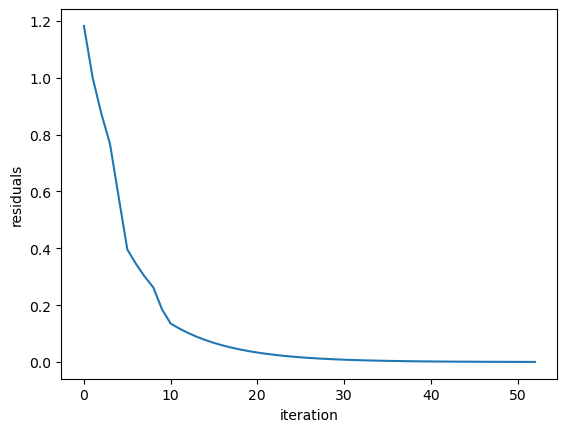

In [365]:
import matplotlib.pyplot as plt

plt.plot(result["r_history"])
plt.xlabel("iteration")
plt.ylabel("residuals")
plt.show()